In [ ]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Pandas para visualización

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
sns.set(style='whitegrid')

%matplotlib inline

# Semillas para reproducibles

random_state = 42


#### Carga de datos y visión general

En este paso vamos a cargar el archivo, ver las dimensiones generales de la tabla, revisar los nombres de las columnas y sus tipos de dato y echar un vistazo rápido a las primeras filas.

Con esto tenemos un mapa general del dataset antes de meternos a limpiar y transformar cosas.



In [2]:

# Cargamos archivo y generales
df = pd.read_csv('Tokyo.csv')

# Dimensiones, nombres de oclumnas, tipos de datos y head

print(f"dimensiones del dataframe: {df.shape[0]} filas, {df.shape[1]} columnas\n")
print("nombres de columnas:")
print(df.columns.tolist(), "\n")

print("tipos de dato por columna:")
print(df.dtypes, "\n")

df.head()




dimensiones del dataframe: 11669 filas, 14 columnas

nombres de columnas:
['departure_date', 'arrival_date', 'company', 'duration', 'stops', 'emissions', 'price', 'price_type', 'departure_airport', 'arrival_airport', 'date_added', 'days', 'partida', 'regreso'] 

tipos de dato por columna:
departure_date       object
arrival_date         object
company              object
duration             object
stops                object
emissions            object
price                object
price_type           object
departure_airport    object
arrival_airport      object
date_added           object
days                  int64
partida              object
regreso              object
dtype: object 



,departure_date,arrival_date,company,duration,stops,emissions,price,price_type,departure_airport,arrival_airport,date_added,days,partida,regreso
0,7:10 AM,3:55 PM+1,AmericanJAL,17 hr 45 min,1 stop,754 kg CO2e,"MX$34,649",round trip,Guadalajara International Airport,Guadalajara International Airport,2025-03-12 14:35:00,7,08-01-2025,08-08-2025
1,6:00 AM,9:00 PM+1,"Alaska, Asiana AirlinesHawaiian, ANA",24 hr,2 stops,"1,060 kg CO2e","MX$36,345",round trip,Guadalajara International Airport,Guadalajara International Airport,2025-03-12 14:35:00,7,08-01-2025,08-08-2025
2,6:00 AM,4:35 PM+1,"Alaska, JAL",19 hr 35 min,1 stop,730 kg CO2e,"MX$37,212",round trip,Guadalajara International Airport,Guadalajara International Airport,2025-03-12 14:35:00,7,08-01-2025,08-08-2025
3,6:00 AM,2:20 PM+1,"Alaska, American",17 hr 20 min,1 stop,709 kg CO2e,"MX$40,727",round trip,Guadalajara International Airport,Guadalajara International Airport,2025-03-12 14:35:00,7,08-01-2025,08-08-2025
4,6:40 AM,3:25 PM+1,"United, ANA",17 hr 45 min,1 stop,746 kg CO2e,"MX$48,895",round trip,Guadalajara International Airport,Guadalajara International Airport,2025-03-12 14:35:00,7,08-01-2025,08-08-2025


#### Analisis de nulos y cantidad de datos

Veremos cuántos valores nulos hay por columna, calcularemos el porcentaje de nulos. Pondremos atención especial en `price`, `price_type`, `duration`, `emissions` y las fechas para por ultimo identificar posibles problemas de calidad de datos para tenerlos presentes antes de limpiar.

In [3]:
# revisamos nulos por columna (conteo y porcentaje)
null_counts = df.isna().sum()
null_percent = df.isna().mean() * 100

null_summary = pd.DataFrame({
    'nulos': null_counts,
    'porcentaje_nulos': null_percent.round(2)
}).sort_values(by='porcentaje_nulos', ascending=False)

null_summary


,nulos,porcentaje_nulos
price_type,88,0.75
departure_date,0,0.00
arrival_date,0,0.00
company,0,0.00
duration,0,0.00
stops,0,0.00
emissions,0,0.00
price,0,0.00
departure_airport,0,0.00
arrival_airport,0,0.00


In [4]:
# Zoom a las que más nos interesan para el precio
cols_clave = ['price', 'price_type', 'duration', 'emissions', 'date_added', 'days', 'partida', 'regreso']

null_summary_clave = null_summary.loc[cols_clave]
null_summary_clave


,nulos,porcentaje_nulos
price,0,0.00
price_type,88,0.75
duration,0,0.00
emissions,0,0.00
date_added,0,0.00
days,0,0.00
partida,0,0.00
regreso,0,0.00


#### Breve analisis del paso anterior

Aquí debes revisar la tabla de `null_summary` y `null_summary_clave` y describir con tus propias palabras cosas como:

`price_type` es en definitiva la columna con más nulos con un 0.75%, price no tiene nulos, y los demás parecen estar limpios.


#### Análisis específico de `price` y `price_type`

En este paso vamos a hacerle zoom a dos columnas clave:

- `price`: donde viene el precio del vuelo en texto.
- `price_type`: que indica si el vuelo es de tipo "round trip" o viene nulo.



In [5]:
# Vemos el conteo de valores en price_type, incluyendo los nulos
df['price_type'].value_counts(dropna=False)


price_type
round trip    11581
NaN              88
Name: count, dtype: int64

In [6]:
# Enfocamos en las filas donde price_type es nulo
mask_price_type_null = df['price_type'].isna()
df_null_price_type = df[mask_price_type_null]

# Revisamos algunas columnas clave de esas filas
df_null_price_type[['price', 'stops', 'company']].head(10)


,price,stops,company
106,Price unavailable,2 stops,Aeromexico
6122,Price unavailable,2 stops,"Aeromexico, JALWestJet"
6175,Price unavailable,2 stops,"Aeromexico, JALWestJet"
6210,Price unavailable,2 stops,"Aeromexico, JALWestJet"
6226,Price unavailable,2 stops,"Aeromexico, JALWestJet"
6407,Price unavailable,2 stops,"Aeromexico, JALWestJet"
6419,Price unavailable,2 stops,"Aeromexico, JALWestJet"
6431,Price unavailable,2 stops,"Aeromexico, JALWestJet"
6525,Price unavailable,2 stops,"Aeromexico, JALWestJet"
6539,Price unavailable,2 stops,"Aeromexico, JALWestJet"


In [7]:
# Revisamos los valores de price dentro de las filas con price_type nulo
df_null_price_type['price'].value_counts().head(10)


price
Price unavailable    88
Name: count, dtype: int64

In [8]:
# Revisamos si en toda la columna price aparecen textos raros como 'Price unavailable'
df['price'].astype(str).value_counts().head(20)


price
MX$29,752            223
MX$28,757            135
MX$28,796            120
MX$31,763             90
Price unavailable     88
MX$33,552             78
MX$30,709             77
MX$29,714             76
MX$31,771             75
MX$25,975             67
MX$30,711             63
MX$29,778             62
MX$31,686             56
MX$32,777             52
MX$30,805             52
MX$31,571             52
MX$26,798             51
MX$33,696             51
MX$33,543             50
MX$34,988             48
Name: count, dtype: int64

### comentario sobre `price_type` y su utilidad

Lo que logramos observar:

- `price_type` solo tiene una categoría informativa (`"round trip"`) y 88 valores nulos.
- En general, el hecho de que casi todos los registros etiquetados sean `"round trip"` y que los nulos no aporten algo diferente hace que `price_type` sea constante y poco útil para el modelo.

Por eso:
- Nos vamos a quedar solo con las filas donde el `price` se pueda convertir a número (vamos a limpiar precios en el siguiente paso), y una vez confirmemos que todos los vuelos del dataset son redondos, vamos a eliminar `price_type` porque no agrega información nueva para predecir el precio.

Previamente teniamos en cuenta solo considerar los vuelos redondos, pero vamos a darle el espacio al analisis que construimos para llegar a ese punto.


#### Limpieza de la variable objetivo `price_mxn`

Vamos a crear una nueva columna numérica `price_mxn` a partir de `price`, ahí vamos a identificar las filas donde el precio no se puede usar (por ejemplo `"Price unavailable"`), para eliminar esas filas del dataframe limpio, y revisarremos rápido con la distribución de `price_mxn`.


In [9]:
df_clean = df.copy()

# limpiamos la columna de price y la convertimos a numerica
# aqui:
# - quitamos el prefijo 'MX$'
# - quitamos comas
# - recortamos espacios
# - usamos to_numeric con errors='coerce' para mandar a NaN lo que no sea numero (por ejemplo 'Price unavailable')
price_str = (
    df_clean['price']
    .astype(str)
    .str.replace('MX\$', '', regex=True)
    .str.replace(',', '', regex=False)
    .str.strip()
)

df_clean['price_mxn'] = pd.to_numeric(price_str, errors='coerce')

price_na_count = df_clean['price_mxn'].isna().sum()
total_rows = df_clean.shape[0]

print(f"filas sin precio numerico (price_mxn NA): {price_na_count}")
print(f"porcentaje del total: {price_na_count / total_rows * 100:.2f}%")


filas sin precio numerico (price_mxn NA): 88
porcentaje del total: 0.75%


<>:12: SyntaxWarning: invalid escape sequence '\$'
<>:12: SyntaxWarning: invalid escape sequence '\$'
C:\Users\hecto\AppData\Local\Temp\ipykernel_17780\93496389.py:12: SyntaxWarning: invalid escape sequence '\$'
  .str.replace('MX\$', '', regex=True)


In [10]:
# resumen estadistico de price_mxn antes de eliminar nulos
df_clean['price_mxn'].describe()


count    11,581.00
mean     37,855.70
std      16,178.82
min      18,614.00
25%      29,752.00
50%      33,264.00
75%      39,469.00
max     219,818.00
Name: price_mxn, dtype: float64

In [11]:
df_clean = df_clean.dropna(subset=['price_mxn']).reset_index(drop=True)
print(f"dimensiones despues de limpiar price_mxn: {df_clean.shape[0]} filas, {df_clean.shape[1]} columnas")


dimensiones despues de limpiar price_mxn: 11581 filas, 15 columnas


#### Breve analisis paso anterior

Los precios que venían como `"Price unavailable"` se eliminan, estas filas representan una fracción pequeña del dataset.

Con esto dejamos listo `df_clean['price_mxn']` como la versión limpia de la variable objetivo.

In [12]:
df_clean = df.copy()

# limpiamos la columna de price y la convertimos a numerica
price_str = (
    df_clean['price']
    .astype(str)
    .str.replace('MX$', '', regex=False)
    .str.replace(',', '', regex=False)
    .str.strip()
)

df_clean['price_mxn'] = pd.to_numeric(price_str, errors='coerce')

# revisamos cuantas filas se quedaron sin precio numerico
price_na_count = df_clean['price_mxn'].isna().sum()
total_rows = df_clean.shape[0]

print(f"filas sin precio numerico (price_mxn NaN): {price_na_count}")
print(f"porcentaje del total: {price_na_count / total_rows * 100:.2f}%")

# eliminamos las filas donde no hay precio numerico usable
df_clean = df_clean.dropna(subset=['price_mxn']).reset_index(drop=True)

print(f"dimensiones despues de limpiar price_mxn: {df_clean.shape[0]} filas, {df_clean.shape[1]} columnas")

df_clean['price_mxn'].describe()


filas sin precio numerico (price_mxn NaN): 88
porcentaje del total: 0.75%
dimensiones despues de limpiar price_mxn: 11581 filas, 15 columnas


count    11,581.00
mean     37,855.70
std      16,178.82
min      18,614.00
25%      29,752.00
50%      33,264.00
75%      39,469.00
max     219,818.00
Name: price_mxn, dtype: float64

#### Construcción de variables limpias (`duration_min`, `stops_num`, `emissions_kg`)

ahora vamos a:
- Convertir `duration` a una columna numérica `duration_min` en minutos,
- Convertir `stops` a `stops_num`,
- Convertir `emissions` a `emissions_kg` numérica.

In [13]:
import re

def parse_duration_to_min(text):
    if pd.isna(text):
        return np.nan
    
    s = str(text).lower()
    hours = 0
    minutes = 0
    
    match_hr = re.search(r'(\d+)\s*hr', s)
    if match_hr:
        hours = int(match_hr.group(1))
    
    match_min = re.search(r'(\d+)\s*min', s)
    if match_min:
        minutes = int(match_min.group(1))
    
    total = hours * 60 + minutes
    return total if total > 0 else np.nan

def parse_stops_to_num(text):
    if pd.isna(text):
        return np.nan
    
    s = str(text).lower().strip()
    
    if 'nonstop' in s:
        return 0
    
    match = re.search(r'(\d+)', s)
    if match:
        return int(match.group(1))
    
    return np.nan

def parse_emissions_to_kg(text):
    if pd.isna(text):
        return np.nan
    
    s = str(text)
    s = s.replace('kg CO2e', '').replace('kg co2e', '')
    s = s.replace(',', '').strip()
    
    return pd.to_numeric(s, errors='coerce')

df_clean['duration_min'] = df_clean['duration'].apply(parse_duration_to_min)
df_clean['stops_num'] = df_clean['stops'].apply(parse_stops_to_num)
df_clean['emissions_kg'] = df_clean['emissions'].apply(parse_emissions_to_kg)

# revisamos nulos en las nuevas columnas
print("nulos en columnas nuevas:")
print(df_clean[['duration_min', 'stops_num', 'emissions_kg']].isna().sum())

df_clean[['price_mxn', 'duration_min', 'stops_num', 'emissions_kg']].describe()


nulos en columnas nuevas:
duration_min      0
stops_num         0
emissions_kg    198
dtype: int64


,price_mxn,duration_min,stops_num,emissions_kg
count,"11,581.00","11,581.00","11,581.00","11,383.00"
mean,"37,855.70","1,550.00",1.58,826.75
std,"16,178.82",414.72,0.50,164.61
min,"18,614.00","1,020.00",1.00,596.00
25%,"29,752.00","1,220.00",1.00,688.00
50%,"33,264.00","1,400.00",2.00,784.00
75%,"39,469.00","1,905.00",2.00,957.00
max,"219,818.00","4,328.00",3.00,"2,537.00"


Con esto ya tenemos cuatro variables numéricas importantes para el modelo:
- `price_mxn`,
- `duration_min`,
- `stops_num`,
- `emissions_kg`.

#### Tratamiento de fechas y validación de la columna `days`

En este paso vamos a:
- Convertir las columnas de fecha (`date_added`, `partida`, `regreso`) a formato datetime,
- Calcular los días de viaje a partir de `partida` y `regreso`,
- Comparar esos días calculados contra la columna `days` que ya viene en el dataset,
- Terminar de cerrar la idea de que todos los vuelos son viajes redondos similares.


In [14]:
# convertimos las fechas a tipo datetime
df_clean['date_added_dt'] = pd.to_datetime(df_clean['date_added'], errors='coerce')

df_clean['partida_date'] = pd.to_datetime(df_clean['partida'], format='%m-%d-%Y', errors='coerce')
df_clean['regreso_date'] = pd.to_datetime(df_clean['regreso'], format='%m-%d-%Y', errors='coerce')

# calculamos los dias de viaje
df_clean['days_from_dates'] = (df_clean['regreso_date'] - df_clean['partida_date']).dt.days

comparacion_days = df_clean[['days', 'days_from_dates']].describe()
print(comparacion_days)

diff_mask = df_clean['days'] != df_clean['days_from_dates']
print("\nfilas donde 'days' y 'days_from_dates' difieren:")
print(diff_mask.sum())


           days  days_from_dates
count 11,581.00        11,581.00
mean      22.00            22.00
std        5.74             5.74
min        7.00             7.00
25%       15.00            15.00
50%       22.00            22.00
75%       29.00            29.00
max       29.00            29.00

filas donde 'days' y 'days_from_dates' difieren:
0


In [15]:
# Algunas filas de ejemplo para asegurarnos de que la diferencia no exista
df_clean.loc[diff_mask, ['partida', 'regreso', 'days', 'days_from_dates']].head(10)


,partida,regreso,days,days_from_dates


In [16]:

print(df_clean['price_type'].value_counts(dropna=False))

if df_clean['price_type'].nunique(dropna=False) == 1:
    df_clean = df_clean.drop(columns=['price_type'])
    print("\ncolumna 'price_type' eliminada del df_clean por ser constante y no aportar informacion al modelo.")
else:
    print("\n'price_type' tiene mas de un valor distinto, revisa si conviene mantenerla.")


price_type
round trip    11581
Name: count, dtype: int64

columna 'price_type' eliminada del df_clean por ser constante y no aportar informacion al modelo.


#### Estadistica descriptiva de variables numericas

En este paso vamos a revisar un resumen general de las variables numericas importantes, ver como se comporta el precio segun el numero de escalas (`stops_num`), ver el precio segun la duracion del viaje en dias (`days`), revisar diferencias de precio promedio por aerolinea (`company`).

In [17]:
num_cols = ['price_mxn', 'duration_min', 'stops_num', 'emissions_kg', 'days']
df_clean[num_cols].describe()


,price_mxn,duration_min,stops_num,emissions_kg,days
count,"11,581.00","11,581.00","11,581.00","11,383.00","11,581.00"
mean,"37,855.70","1,550.00",1.58,826.75,22.00
std,"16,178.82",414.72,0.50,164.61,5.74
min,"18,614.00","1,020.00",1.00,596.00,7.00
25%,"29,752.00","1,220.00",1.00,688.00,15.00
50%,"33,264.00","1,400.00",2.00,784.00,22.00
75%,"39,469.00","1,905.00",2.00,957.00,29.00
max,"219,818.00","4,328.00",3.00,"2,537.00",29.00


In [18]:
precio_por_stops = (
    df_clean
    .groupby('stops_num')['price_mxn']
    .agg(['count', 'mean', 'median', 'min', 'max'])
    .round(2)
)

precio_por_stops


,count,mean,median,min,max
stops_num,,,,,
1,4920,"37,363.76","33,182.00","18,614.00","186,818.00"
2,6654,"38,195.94","33,283.50","20,485.00","219,818.00"
3,7,"60,192.86","57,210.00","53,730.00","69,426.00"


In [19]:
# precio promedio por cantidad de dias de viaje
precio_por_days = (
    df_clean
    .groupby('days')['price_mxn']
    .agg(['count', 'mean', 'median', 'min', 'max'])
    .round(2)
)

# mostramos las primeras filas para no saturar
precio_por_days.head(15)


,count,mean,median,min,max
days,,,,,
7,24,"49,595.25","44,392.50","34,649.00","98,592.00"
15,3820,"37,963.76","33,128.50","18,614.00","181,667.00"
22,3871,"37,947.62","33,200.00","19,456.00","219,818.00"
29,3866,"37,584.00","33,443.50","20,107.00","218,044.00"


In [20]:
# precio promedio por aerolinea
precio_por_company = (
    df_clean
    .groupby('company')
    .agg(
        count=('price_mxn', 'count'),
        mean_price=('price_mxn', 'mean')
    )
    .query('count >= 30')
    .sort_values('mean_price')
    .round(2)
)

precio_por_company.head(15)


,count,mean_price
company,,
WestJet,69,"26,445.17"
Air Canada,274,"27,577.31"
"Alaska, Hawaiian",222,"28,450.19"
"Alaska, Asiana Airlines",424,"28,622.84"
"Alaska, JALAmerican",69,"29,188.13"
UnitedOperated by SkyWest DBA United Express,233,"30,899.79"
"United, ANAOperated by SkyWest DBA United Express",273,"31,761.53"
"Alaska, China Airlines",64,"32,192.17"
UnitedANA,429,"32,524.76"


#### Exploracion visual univariada y `log_price`

Ahora vamos a:
- Crear la variable `log_price` a partir de `price_mxn`,
- Ver un resumen estadistico rapido,
- Graficar el histograma de `price_mxn`,
- Graficar el histograma de `log_price`,


In [21]:
# creamos la columna log_price usando precio en mxn
df_clean['log_price'] = np.log(df_clean['price_mxn'])

# resumen
df_clean[['price_mxn', 'log_price']].describe()


,price_mxn,log_price
count,"11,581.00","11,581.00"
mean,"37,855.70",10.49
std,"16,178.82",0.30
min,"18,614.00",9.83
25%,"29,752.00",10.30
50%,"33,264.00",10.41
75%,"39,469.00",10.58
max,"219,818.00",12.30


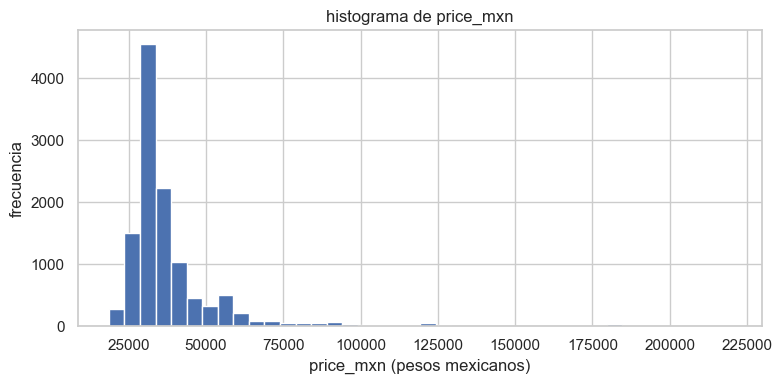

In [22]:
plt.figure(figsize=(8, 4))
plt.hist(df_clean['price_mxn'], bins=40)
plt.xlabel('price_mxn (pesos mexicanos)')
plt.ylabel('frecuencia')
plt.title('histograma de price_mxn')
plt.tight_layout()
plt.show()


Obtuvimos lo que creiamos, una distribución que queda completamente sesgada a la derach, eso habla de muchos vuelos 'normales' y muchos muy caros que jalan a ese sesgo.

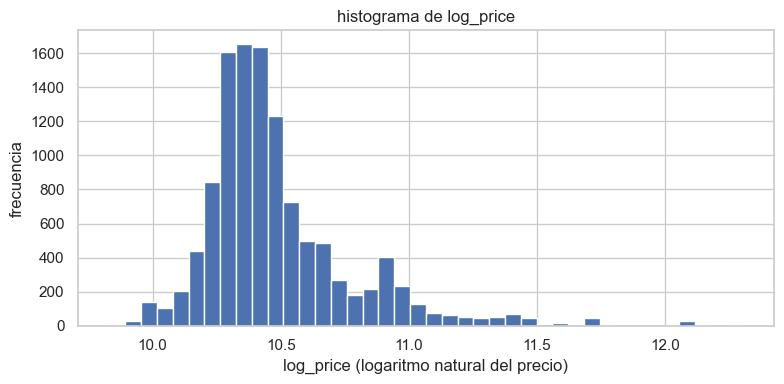

In [23]:
plt.figure(figsize=(8, 4))
plt.hist(df_clean['log_price'], bins=40)
plt.xlabel('log_price (logaritmo natural del precio)')
plt.ylabel('frecuencia')
plt.title('histograma de log_price')
plt.tight_layout()
plt.show()


Mucho más simetrico, pero aún sesgado, sin embargo vale la pena considerarlo como candidaro para para pricee

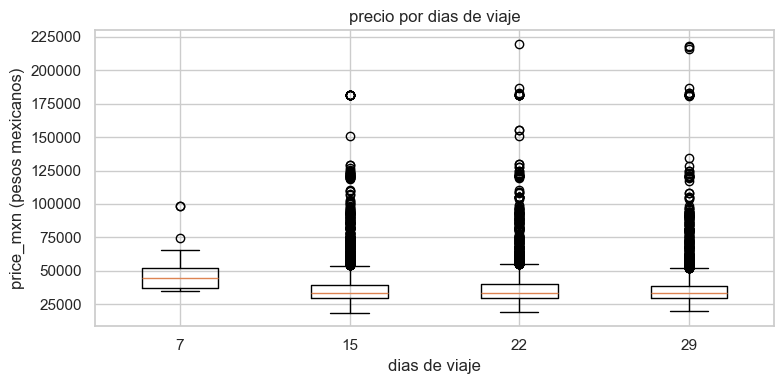

In [24]:
## boxplot de price_mxn por dias de viaje

plt.figure(figsize=(8, 4))
plt.boxplot(
    [df_clean.loc[df_clean['days'] == d, 'price_mxn'] for d in sorted(df_clean['days'].unique())],
    labels=sorted(df_clean['days'].unique())
)
plt.xlabel('dias de viaje')
plt.ylabel('price_mxn (pesos mexicanos)')
plt.title('precio por dias de viaje')
plt.tight_layout()
plt.show()



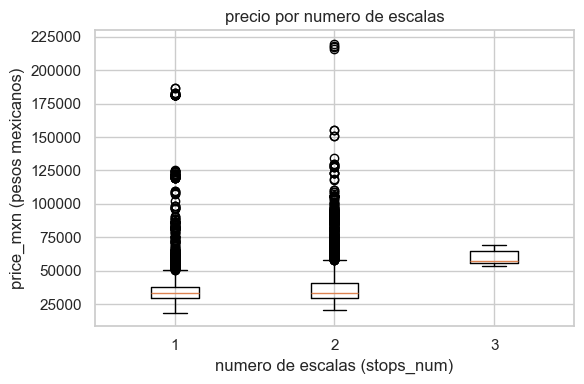

In [25]:
## boxplot de price_mxn por numero de escalas

plt.figure(figsize=(6, 4))
plt.boxplot(
    [df_clean.loc[df_clean['stops_num'] == s, 'price_mxn'] for s in sorted(df_clean['stops_num'].unique())],
    labels=sorted(df_clean['stops_num'].unique())
)
plt.xlabel('numero de escalas (stops_num)')
plt.ylabel('price_mxn (pesos mexicanos)')
plt.title('precio por numero de escalas')
plt.tight_layout()
plt.show()

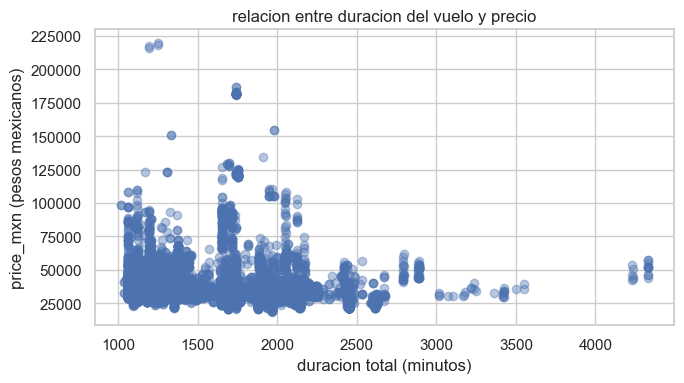

In [26]:
## scatter de price_mxn vs duration_min

plt.figure(figsize=(7, 4))
plt.scatter(df_clean['duration_min'], df_clean['price_mxn'], alpha=0.4)
plt.xlabel('duracion total (minutos)')
plt.ylabel('price_mxn (pesos mexicanos)')
plt.title('relacion entre duracion del vuelo y precio')
plt.tight_layout()
plt.show()


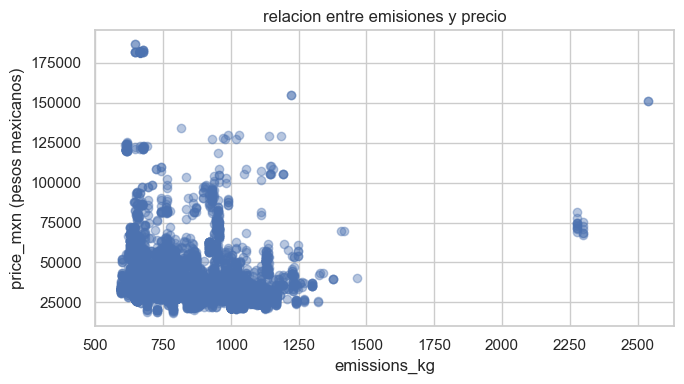

In [27]:
## scatter de price_mxn vs emissions_kg

mask_emissions = df_clean['emissions_kg'].notna()
plt.figure(figsize=(7, 4))
plt.scatter(df_clean.loc[mask_emissions, 'emissions_kg'],
            df_clean.loc[mask_emissions, 'price_mxn'],
            alpha=0.4)
plt.xlabel('emissions_kg')
plt.ylabel('price_mxn (pesos mexicanos)')
plt.title('relacion entre emisiones y precio')
plt.tight_layout()
plt.show()


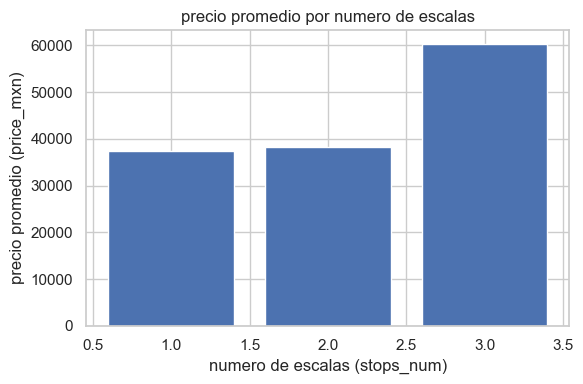

,stops_num,price_mxn
0,1,"37,363.76"
1,2,"38,195.94"
2,3,"60,192.86"


In [28]:
## grafica de barras: precio promedio por numero de escalas

precio_por_stops_plot = (
    df_clean
    .groupby('stops_num')['price_mxn']
    .mean()
    .round(2)
    .reset_index()
)

plt.figure(figsize=(6, 4))
plt.bar(precio_por_stops_plot['stops_num'], precio_por_stops_plot['price_mxn'])
plt.xlabel('numero de escalas (stops_num)')
plt.ylabel('precio promedio (price_mxn)')
plt.title('precio promedio por numero de escalas')
plt.tight_layout()
plt.show()

precio_por_stops_plot

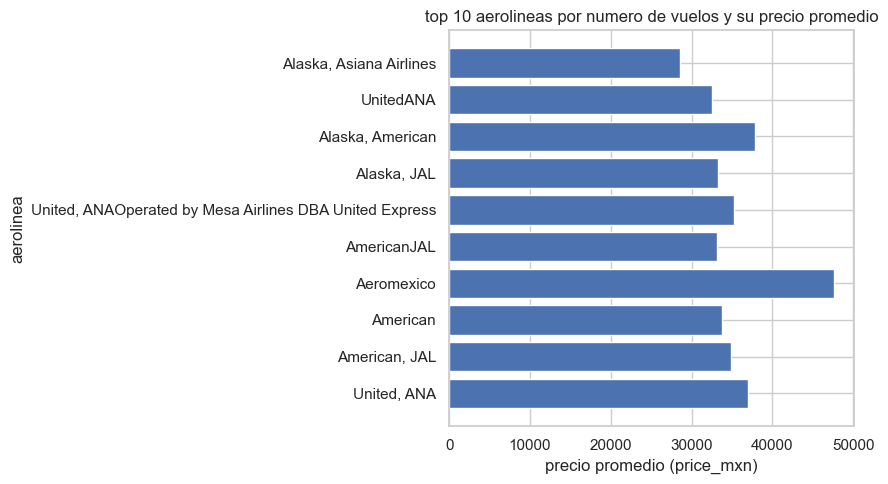

,company,count,mean_price
0,"United, ANA",1481,"36,984.52"
1,"American, JAL",1430,"34,923.80"
2,American,1290,"33,745.45"
3,Aeromexico,950,"47,685.13"
4,AmericanJAL,695,"33,120.73"
5,"United, ANAOperated by Mesa Airlines DBA Unite...",505,"35,208.93"
6,"Alaska, JAL",469,"33,278.36"
7,"Alaska, American",451,"37,883.06"
8,UnitedANA,429,"32,524.76"
9,"Alaska, Asiana Airlines",424,"28,622.84"


In [29]:
## grafica de barras del precio promedio por aerolinea

company_stats = (
    df_clean
    .groupby('company')
    .agg(
        count=('price_mxn', 'count'),
        mean_price=('price_mxn', 'mean')
    )
    .sort_values('count', ascending=False)
)

top_companies = company_stats.head(10).reset_index()

plt.figure(figsize=(9, 5))
plt.barh(top_companies['company'], top_companies['mean_price'])
plt.xlabel('precio promedio (price_mxn)')
plt.ylabel('aerolinea')
plt.title('top 10 aerolineas por numero de vuelos y su precio promedio')
plt.tight_layout()
plt.show()

top_companies


#### Matriz de correlaciones entre variables numericas

Calculamos la matriz de correlacion entre las variables numericas mas importantes,

In [30]:
num_cols_corr = ['price_mxn', 'log_price', 'duration_min', 'stops_num', 'emissions_kg', 'days']

corr_matrix = df_clean[num_cols_corr].corr()
corr_matrix


,price_mxn,log_price,duration_min,stops_num,emissions_kg,days
price_mxn,1.00,0.95,-0.04,0.03,-0.12,-0.01
log_price,0.95,1.00,-0.08,0.04,-0.16,-0.01
duration_min,-0.04,-0.08,1.00,0.17,0.29,0.01
stops_num,0.03,0.04,0.17,1.00,0.50,-0.00
emissions_kg,-0.12,-0.16,0.29,0.50,1.00,-0.02
days,-0.01,-0.01,0.01,-0.00,-0.02,1.00


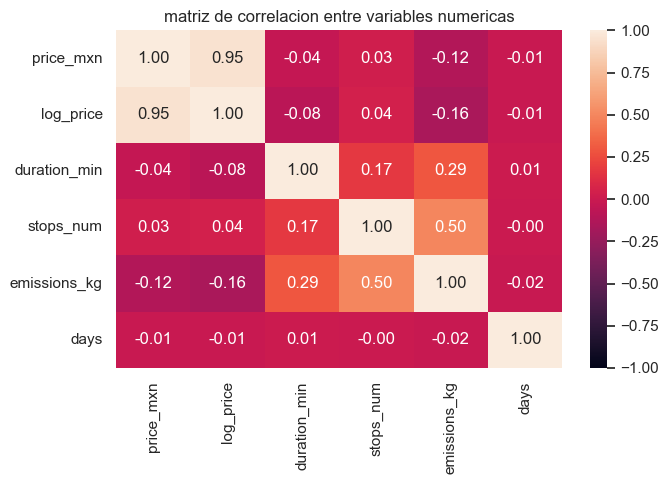

In [31]:
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.title('matriz de correlacion entre variables numericas')
plt.tight_layout()
plt.show()


#### Decision explicita sobre la variable objetivo

Despues de revisar:

- La distribucion original de `price_mxn`, que esta muy sesgada a la derecha,
- La distribucion de `log_price`, que se ve mas compacta y bastante mas simetrica,
- Y la matriz de correlacion, donde `price_mxn` y `log_price` estan muy correlacionados entre si (0.95), pero el resto de variables no muestran relaciones lineales extremas,

La decision es la siguiente:

- **Variable objetivo principal** para los modelos: `log_price`.
  - Esto ayuda a:
    - Reducir el impacto de los vuelos extremadamente caros,
    - Acercar la distribucion a algo mas “normal”,
    - Y suele mejorar la estabilidad de modelos lineales.
- **Variable objetivo alternativa / de interpretacion**: `price_mxn`.
  - La vamos a usar para:
    - Reportar resultados en pesos (haciendo `np.exp` a las predicciones de `log_price`),
    - Y, si hace falta, probar al menos un modelo directamente sobre `price_mxn` para comparar.


In [32]:
target_main = 'log_price'
target_raw = 'price_mxn'

print("variable objetivo principal para modelado:", target_main)
print("variable de precio original para interpretacion:", target_raw)


variable objetivo principal para modelado: log_price
variable de precio original para interpretacion: price_mxn


#### AHORA SÍ: Armado del dataset de modelado

- Construir un dataframe de modelado (`df_model`) a partir de `df_clean`,
- Elegir las variables que vamos a usar como predictores (features),
- Dejar claro que el objetivo principal es `log_price`,
- Separar las matrices `X` (features) y `y` (target),
- Hacer el split train/test.

en los siguientes pasos ya metemos el `ColumnTransformer` con one-hot encoding para `company` y escalado para las numericas.


In [33]:
# definimos features y target
feature_cols_num = ['duration_min', 'stops_num', 'emissions_kg', 'days']
feature_cols_cat = ['company']

target_main = 'log_price'
target_raw = 'price_mxn'

# construimos un dataframe
cols_model = feature_cols_num + feature_cols_cat + [target_main, target_raw]
df_model = df_clean[cols_model].copy()

print("nulos por columna en df_model:")
print(df_model.isna().sum())

# eliminamos nulos
df_model = df_model.dropna(subset=feature_cols_num + feature_cols_cat + [target_main]).reset_index(drop=True)

print("\nforma final de df_model despues de eliminar nulos:")
print(df_model.shape)

df_model.head()


nulos por columna en df_model:
duration_min      0
stops_num         0
emissions_kg    198
days              0
company           0
log_price         0
price_mxn         0
dtype: int64

forma final de df_model despues de eliminar nulos:
(11383, 7)


,duration_min,stops_num,emissions_kg,days,company,log_price,price_mxn
0,1065,1,754.00,7,AmericanJAL,10.45,"34,649.00"
1,1440,2,"1,060.00",7,"Alaska, Asiana AirlinesHawaiian, ANA",10.50,"36,345.00"
2,1175,1,730.00,7,"Alaska, JAL",10.52,"37,212.00"
3,1040,1,709.00,7,"Alaska, American",10.61,"40,727.00"
4,1065,1,746.00,7,"United, ANA",10.80,"48,895.00"


Listo el **dataframe**

In [34]:
from sklearn.model_selection import train_test_split

# definimos features y (target)
X = df_model[feature_cols_num + feature_cols_cat]
y = df_model[target_main]

# spliteamos
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("dimensiones de los conjuntos:")
print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")


dimensiones de los conjuntos:
X_train: (9106, 5)
X_test:  (2277, 5)
y_train: (9106,)
y_test:  (2277,)


Nuestro **primer modelo base**:

- Preprocesamiento con `ColumnTransformer`:
  - numericas (`duration_min`, `stops_num`, `emissions_kg`, `days`) → `StandardScaler`
  - categorica (`company`) → `OneHotEncoder`
- Empaquetamos todo en un `Pipeline` para que el preprocesamiento se aplique dentro del flujo del modelo.
- Definimos una funcion de ayuda para evaluar cualquier modelo con las metricas:
  - `MSE`, `RMSE`, `MAE`, `R²`
  - Tanto en train como en test (para revisar overfitting / underfitting).


In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# transformador para numericas
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# transformador para categoricas
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, feature_cols_num),
        ('cat', categorical_transformer, feature_cols_cat)
    ]
)

# pipeline completo
linreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

linreg_pipeline.fit(X_train, y_train)

# funcion de apoyo para evaluar modelos
def evaluar_modelo(nombre, modelo, X_train, y_train, X_test, y_test):
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)
    
    filas = []
    for split_name, y_true, y_pred in [
        ('train', y_train, y_pred_train),
        ('test',  y_test,  y_pred_test)
    ]:
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        filas.append({
            'modelo': nombre,
            'conjunto': split_name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })
    
    return pd.DataFrame(filas)

# evaluamos
resultados_linreg = evaluar_modelo(
    'LinearRegression',
    linreg_pipeline,
    X_train, y_train,
    X_test, y_test
)

resultados_linreg

pd.set_option('display.precision', 6)
resultados_linreg

,modelo,conjunto,MSE,RMSE,MAE,R2
0,LinearRegression,train,0.04,0.20,0.14,0.53
1,LinearRegression,test,0.04,0.20,0.15,0.53


#### Otros modelos

Ahora vamos a probar **3 modelos adicionales** usando exactamente el mismo esquema de preprocesamiento:

- `Ridge`
- `Lasso`
- `RandomForestRegressor`

Todavía nada de tuning.

In [36]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# pipeline ridge
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

# pipeline lasso
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso())
])

# pipeline random forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

# entrenamos todos
ridge_pipeline.fit(X_train, y_train)
lasso_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

# evaluamos todos
resultados_ridge = evaluar_modelo('Ridge', ridge_pipeline, X_train, y_train, X_test, y_test)
resultados_lasso = evaluar_modelo('Lasso', lasso_pipeline, X_train, y_train, X_test, y_test)
resultados_rf = evaluar_modelo('RandomForest', rf_pipeline, X_train, y_train, X_test, y_test)

# tablita
resultados_todos = pd.concat(
    [resultados_linreg, resultados_ridge, resultados_lasso, resultados_rf],
    ignore_index=True
)

resultados_todos


,modelo,conjunto,MSE,RMSE,MAE,R2
0,LinearRegression,train,0.04,0.20,0.14,0.53
1,LinearRegression,test,0.04,0.20,0.15,0.53
2,Ridge,train,0.04,0.20,0.14,0.53
3,Ridge,test,0.04,0.20,0.15,0.53
4,Lasso,train,0.08,0.29,0.21,0.00
5,Lasso,test,0.09,0.30,0.21,-0.00
6,RandomForest,train,0.01,0.11,0.07,0.86
7,RandomForest,test,0.02,0.14,0.09,0.77


#### Paso 5: Agregamos BoostingRegressor en lugar de XGBoost por temas estructurales

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

# pipeline con gradient boosting
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(
        random_state=42
    ))
])

# entrenamos gradient boosting
gb_pipeline.fit(X_train, y_train)

# evaluamos gradient boosting con la misma funcion
resultados_gb = evaluar_modelo(
    'GradientBoosting',
    gb_pipeline,
    X_train, y_train,
    X_test, y_test
)

# actualizamos la tabla
resultados_todos = pd.concat(
    [resultados_todos, resultados_gb],
    ignore_index=True
)

resultados_todos


,modelo,conjunto,MSE,RMSE,MAE,R2
0,LinearRegression,train,0.04,0.20,0.14,0.53
1,LinearRegression,test,0.04,0.20,0.15,0.53
2,Ridge,train,0.04,0.20,0.14,0.53
3,Ridge,test,0.04,0.20,0.15,0.53
4,Lasso,train,0.08,0.29,0.21,0.00
5,Lasso,test,0.09,0.30,0.21,-0.00
6,RandomForest,train,0.01,0.11,0.07,0.86
7,RandomForest,test,0.02,0.14,0.09,0.77
8,GradientBoosting,train,0.03,0.18,0.13,0.63
9,GradientBoosting,test,0.03,0.18,0.13,0.61


#### Ajuste de hiperparametros (ridge y random forest)

En este paso vamos a:

- Ajustar el hiperparametro `alpha` del modelo **ridge** usando `GridSearchCV`
- Ajustar varios hiperparametros de **random forest** usando `RandomizedSearchCV`

El objetivo es mejorar un poco el desempeno en test, todo usando siempre el mismo esquema de preprocesamiento (preprocessor) que ya definimos.


In [38]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# 1) grid search para ridge

# usamos ridge_pipeline
param_grid_ridge = {
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

ridge_grid = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=param_grid_ridge,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

ridge_grid.fit(X_train, y_train)

print("mejores parametros ridge:", ridge_grid.best_params_)

ridge_best = ridge_grid.best_estimator_

resultados_ridge_tuned = evaluar_modelo(
    'Ridge_tuned',
    ridge_best,
    X_train, y_train,
    X_test, y_test
)

print("\nresultados ridge ajustado:")
print(resultados_ridge_tuned)

# 2) randomized search para random forest

# pipeline rf_pipeline
param_dist_rf = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', 0.5]
}

rf_random = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist_rf,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_random.fit(X_train, y_train)

print("\nmejores parametros random forest:", rf_random.best_params_)

rf_best = rf_random.best_estimator_

resultados_rf_tuned = evaluar_modelo(
    'RandomForest_tuned',
    rf_best,
    X_train, y_train,
    X_test, y_test
)

print("\nresultados random forest ajustado:")
print(resultados_rf_tuned)

# Nuestra tablita
resultados_finales = pd.concat(
    [resultados_todos, resultados_ridge_tuned, resultados_rf_tuned],
    ignore_index=True
)

resultados_finales


mejores parametros ridge: {'model__alpha': 0.001}

resultados ridge ajustado:
        modelo conjunto  MSE  RMSE  MAE   R2
0  Ridge_tuned    train 0.04  0.20 0.14 0.53
1  Ridge_tuned     test 0.04  0.20 0.15 0.53
Fitting 3 folds for each of 20 candidates, totalling 60 fits

mejores parametros random forest: {'model__n_estimators': 400, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 0.5, 'model__max_depth': None}

resultados random forest ajustado:
               modelo conjunto  MSE  RMSE  MAE   R2
0  RandomForest_tuned    train 0.01  0.11 0.07 0.86
1  RandomForest_tuned     test 0.02  0.14 0.09 0.77


,modelo,conjunto,MSE,RMSE,MAE,R2
0,LinearRegression,train,0.04,0.20,0.14,0.53
1,LinearRegression,test,0.04,0.20,0.15,0.53
2,Ridge,train,0.04,0.20,0.14,0.53
3,Ridge,test,0.04,0.20,0.15,0.53
4,Lasso,train,0.08,0.29,0.21,0.00
5,Lasso,test,0.09,0.30,0.21,-0.00
6,RandomForest,train,0.01,0.11,0.07,0.86
7,RandomForest,test,0.02,0.14,0.09,0.77
8,GradientBoosting,train,0.03,0.18,0.13,0.63
9,GradientBoosting,test,0.03,0.18,0.13,0.61


#### Resumen del tuneado y eleccion de mejor modelo

Despues del ajuste de hiperparametros vimos lo siguiente:

- **Ridge_tuned** encontro un `alpha = 0.001` y sus metricas quedaron igual que la regresion lineal:
  - r2 0.53 en train y test, mse y rmse igualitos.
  
  Conclusion: el modelo lineal regularizado **no mejora** contra el modelo lineal simple.

- **Randomforest_tuned** eligio:
  - `n_estimators = 400`, `max_depth = None`, `min_samples_split = 2`,
    `min_samples_leaf = 1`, `max_features = 0.5`.
  - Resultados casi iguales que el random forest base:
    - train: r2 0.86
    - test:  r2 0.77
  - Sigue siendo el **mejor modelo del conjunto**, con el mejor r2 y los errores (rmse, mae) mas bajos, y un gap train–test razonable para un modelo de arboles.

  **El mejorm modelo hasta el momento fue Random Forest con ajuste de hiperparametros en RandomizedSearchCV**


#### Predicciones con el mejor modelo sobre vuelos nuevos (sacados del test)

Por ultimo:

- Tomar algunas filas del conjunto de prueba `X_test` como si fueran "vuelos nuevos"
- Usamos el random forest ajustado para predecir `log_price`
- Transformar esas predicciones a pesos (`price_pred_mxn = exp(log_price_pred)`)
- Comparararemos contra el precio real para tener una idea del error en unidades de dinero


In [ ]:
# dejamos explicito el mejor modelo
best_model = rf_best
best_model_name = 'RandomForest_tuned'

print("mejor modelo seleccionado:", best_model_name)


mejor modelo seleccionado: RandomForest_tuned


In [ ]:
import numpy as np

# Agarrams 5 ejemplos del conjunto de test
ejemplos_nuevos = X_test.sample(5, random_state=42).copy()

# predicciones en log
log_price_pred = best_model.predict(ejemplos_nuevos)

price_pred_mxn = np.exp(log_price_pred)

# df de los resultados
resultados_pred = ejemplos_nuevos.copy()
resultados_pred['log_price_pred'] = log_price_pred
resultados_pred['price_pred_mxn'] = price_pred_mxn.round(2)

# agregamos precio real 
resultados_pred['price_real_mxn'] = df_model.loc[ejemplos_nuevos.index, target_raw].values

resultados_pred



,duration_min,stops_num,emissions_kg,days,company,log_price_pred,price_pred_mxn,price_real_mxn
10528,1905,1,767.00,15,American,10.48,"35,545.35","30,729.00"
10975,1372,2,635.00,22,Aeromexico,10.50,"36,373.90","33,520.00"
9748,1905,1,767.00,29,American,10.43,"34,009.77","38,790.00"
10740,1330,2,837.00,22,American,10.28,"29,005.67","29,752.00"
6145,2035,1,729.00,22,"United, ANAOperated by Mesa Airlines DBA Unite...",10.41,"33,225.48","32,777.00"


## Conclusiones

#### Comparacion de los modelos

Despues de probar varios modelos y hacer un ajuste sencillo de hiperparametros, los resultados en el conjunto de **prueba** quedaron, a grandes rasgos, asi:

- **Regresion Lineal y Ridge tuneado**  
  - r2 = 0.53  
  - rmse = 0.20  
  - mae = 0.15  

- **Lasso**  
  - r2 = 0.00  
  - rmse = 0.30  
  - mae = 0.21  

- **GradientBoosting (En lugar de XGBoosting por temas estructurales)**  
  - r2 = 0.61  
  - rmse = 0.18  
  - mae = 0.13  

- **Random Forest (Base y tuneado)**  
  - r2 = 0.77 en test  
  - rmse = 0.14  
  - mae = 0.09  
Es el modelo que **mejor explica la variacion del precio** (en log) y el que tiene menos errores. el tuning mejoro los hiperparametros pero tuvo el mismo desempeño, ya desde antes estaba bien configurado.


#### Analisis de overfitting / underfitting


Del modelo ganador, siendo RandomForest tuneado y base:
  - r2 train = 0.86
  - r2 test = 0.77.  
Hay una brecha entre train y test, pero el r2 en test sigue siendo alto y los errores siguen siendo bajos. podemos decir que hay **algo de sobreajuste controlado**, pero aceptable para este tipo de modelo y este tamaño de muestra.


#### Conclusiones finales

- Definimos como variable objetivo principal **`log_price`**, porque:
  - La distribucion original de `price_mxn` estaba muy sesgada a la derecha,
  - Al aplicar el logaritmo la distribucion se volvio mas simetrica,
  - Los modelos lineales y de arboles trabajan mejor con esta transformacion,

- Usamos un pipeline de preprocesamiento que:
  - Estandariza las variables numericas (`duration_min`, `stops_num`, `emissions_kg`, `days`),
  - Aplica one-hot encoding a la variable categórica `company`,

- Probamos varios modelos:
  - Lineales: `LinearRegression`, `Ridge`, `Lasso`,
  - No lineales: `RandomForestRegressor`, `GradientBoostingRegressor`,
  - Y ajustamos hiperparametros en **ridge** y **random forest** usando `GridSearchCV` y `RandomizedSearchCV`.

- Para comparar modelos usamos:
  - **`R²`** en el conjunto de prueba
  - **`RMSE` y `MAE`** en escala log
  - Y la diferencia entre train y test para **overfitting / underfitting**.

- El **mejor modelo final** fue el **`RandomForestRegressor` ajustado**:
  - r2 = 0.77 en test
  - Desvio de alrededor del 10–15 % del precio real
  - Buen comportamiento entre train y test, solo un overfitting controlado.

## Pruebas extra

1. Ajuste más agresivo con `RandomizedSearchCV`
2. Intentamos con `MLPRegressor`

In [ ]:
# ajuste mas denso de hiperparametros para random forest

param_dist_rf_dense = {
    'model__n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
    'model__max_depth': [None, 5, 8, 10, 12, 15, 20, 25],
    'model__min_samples_split': [2, 3, 4, 5, 6, 8, 10],
    'model__min_samples_leaf': [1, 2, 3, 4],
    'model__max_features': ['sqrt', 'log2', 0.4, 0.5, 0.6, 0.8, 1.0]
}

rf_random_dense = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist_rf_dense,
    n_iter=80,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("iniciando random search denso para random forest...")
rf_random_dense.fit(X_train, y_train)

print("\nmejores parametros random forest (busqueda densa):")
print(rf_random_dense.best_params_)

rf_best_dense = rf_random_dense.best_estimator_

# evaluamos este modelo "denso"
resultados_rf_tuned_dense = evaluar_modelo(
    'RandomForest_tuned_dense',
    rf_best_dense,
    X_train, y_train,
    X_test, y_test
)

print("\nresultados random forest ajustado (busqueda densa):")
print(resultados_rf_tuned_dense)

resultados_finales = pd.concat(
    [resultados_finales, resultados_rf_tuned_dense],
    ignore_index=True
)

resultados_finales


iniciando random search denso para random forest...
Fitting 3 folds for each of 80 candidates, totalling 240 fits

mejores parametros random forest (busqueda densa):
{'model__n_estimators': 450, 'model__min_samples_split': 3, 'model__min_samples_leaf': 1, 'model__max_features': 1.0, 'model__max_depth': None}

resultados random forest ajustado (busqueda densa):
                     modelo conjunto  MSE  RMSE  MAE   R2
0  RandomForest_tuned_dense    train 0.01  0.11 0.07 0.86
1  RandomForest_tuned_dense     test 0.02  0.14 0.09 0.77


,modelo,conjunto,MSE,RMSE,MAE,R2
0,LinearRegression,train,0.04,0.20,0.14,0.53
1,LinearRegression,test,0.04,0.20,0.15,0.53
2,Ridge,train,0.04,0.20,0.14,0.53
3,Ridge,test,0.04,0.20,0.15,0.53
4,Lasso,train,0.08,0.29,0.21,0.00
5,Lasso,test,0.09,0.30,0.21,-0.00
6,RandomForest,train,0.01,0.11,0.07,0.86
7,RandomForest,test,0.02,0.14,0.09,0.77
8,GradientBoosting,train,0.03,0.18,0.13,0.63
9,GradientBoosting,test,0.03,0.18,0.13,0.61


In [ ]:
from sklearn.neural_network import MLPRegressor

# pipeline con red neuronal (mlp)
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        max_iter=300,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=10,
        verbose=True
    ))
])

print("entrenando mlpregressor (red neuronal densa)...")
mlp_pipeline.fit(X_train, y_train)

# evaluamos el mlp con la misma funcion que hemos usado
resultados_mlp = evaluar_modelo(
    'MLPRegressor',
    mlp_pipeline,
    X_train, y_train,
    X_test, y_test
)

print("\nresultados mlpregressor:")
print(resultados_mlp)

resultados_finales = pd.concat(
    [resultados_finales, resultados_mlp],
    ignore_index=True
)

resultados_finales


entrenando mlpregressor (red neuronal densa)...
Iteration 1, loss = 27.59535269
Validation score: -37.511759
Iteration 2, loss = 1.17212174
Validation score: -14.064344
Iteration 3, loss = 0.43936809
Validation score: -8.422662
Iteration 4, loss = 0.28721196
Validation score: -5.321347
Iteration 5, loss = 0.20751099
Validation score: -3.402487
Iteration 6, loss = 0.15540325
Validation score: -2.194023
Iteration 7, loss = 0.11782482
Validation score: -1.423279
Iteration 8, loss = 0.08986469
Validation score: -0.696584
Iteration 9, loss = 0.06678717
Validation score: -0.270599
Iteration 10, loss = 0.05065837
Validation score: 0.018664
Iteration 11, loss = 0.03921539
Validation score: 0.175118
Iteration 12, loss = 0.03208470
Validation score: 0.278328
Iteration 13, loss = 0.02757890
Validation score: 0.330527
Iteration 14, loss = 0.02460240
Validation score: 0.375364
Iteration 15, loss = 0.02278052
Validation score: 0.389840
Iteration 16, loss = 0.02149595
Validation score: 0.414859
Itera

,modelo,conjunto,MSE,RMSE,MAE,R2
0,LinearRegression,train,0.04,0.20,0.14,0.53
1,LinearRegression,test,0.04,0.20,0.15,0.53
2,Ridge,train,0.04,0.20,0.14,0.53
3,Ridge,test,0.04,0.20,0.15,0.53
4,Lasso,train,0.08,0.29,0.21,0.00
5,Lasso,test,0.09,0.30,0.21,-0.00
6,RandomForest,train,0.01,0.11,0.07,0.86
7,RandomForest,test,0.02,0.14,0.09,0.77
8,GradientBoosting,train,0.03,0.18,0.13,0.63
9,GradientBoosting,test,0.03,0.18,0.13,0.61


No me gustó mucho el comportamiento del MLP regressor